# Mod 5 Project Submission
- Student Name: Juliette Cabrera
- Student pace: Part-Time
- Scheduled project review date/time: 
- Instructor name: Matt Sparr
- Blog post URL: 

# The Question:
- The objective is to use the 2006-2007 school report to build a model that can predict the Quality Review Score of a school and interpret the results to find the factors which influence the score.

# The Process:
Supervised learning - Classification - allows us to tell if something belongs to one class, or the other.  In this particular project, we're doing a multiclass classification problem because we're determining if the school will get a 'quality review score' of well-developed, proficient, or undeveloped.

## Data Used:
- Used the 2006-2007 School Report from NYC OpenData 
- Used https://www.schooldigger.com/go/NY/search.aspx (found in **Webscrape** notebook) to webscrape to find additional features:
    - Enrollment totals
    - Teacher-Student Ratio
    - Percent students who have free/reduced lunch 

## Workflow:
- Data cleaning 
    - includes encoding categorical columns
- EDA (exploratory data analysis)
    - Data visualization
- Compare model performance:
    - KNN (K-Nearest Neighbor) 
        - Note: when working with multiclass/multilabel targets, ```percision_score```, ```recall_score```, and ```f1_score``` need to have an average of : source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
            - micro: calculate metrics globablly by counting the total true positives, false negatives, and false positives.
            - macro: calculate metrics for eachlable, and find their unweighted mean.  This does not take label imbalance into account.
            - weighted: calculate metrics for each label, and find their average weighted by support (the number of true instances for each label).  
            - samples: calculate metrics for each instance, and find their average.
           
    - Decision Tree
    - Random Forest
    - Gradient Boosting
    - Ada Boost
    - XGBoost
- Interpret the findings

# 1. Import all the necessary libraries, data set, and define functions that will be needed.

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from IPython.display import Image
from pydotplus import graph_from_dot_data

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.decomposition import PCA

def print_metrics(labels, preds):
    print('Precision Score: {}'.format(precision_score(labels, preds, average='weighted', zero_division='warn')))
    print('Recall Score: {}'.format(recall_score(labels, preds, average='weighted')))
    print('Accuracy Score: {}'.format(accuracy_score(labels, preds)))
    print('F1 Score: {}'.format(f1_score(labels, preds, average='weighted')))

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 2. Data Cleaning

In [3]:
school_report = pd.read_csv('clean_data.csv')
school_report.head()

Unnamed: 0                           SCHOOL      SCHOOL LEVEL*  \
0           0   BARD HIGH SCHOOL EARLY COLLEGE        High School   
1           1       CHILDREN'S WORKSHOP SCHOOL  Elementary School   
2           2                     EARTH SCHOOL  Elementary School   
3           3  EAST SIDE COMMUNITY HIGH SCHOOL        High School   
4           4     MARTA VALLE SECONDARY SCHOOL        High School   

   PEER INDEX*  GRADE  OVERALL SCORE  ENVIRONMENT CATEGORY SCORE  \
0         3.77      B          57.80                       0.715   
1        39.10      B          56.81                       0.508   
2        41.67      B          55.18                       0.985   
3         2.66      A          71.33                       0.788   
4         2.63      C          36.00                       0.250   

   PERFORMANCE CATEGORY SCORE  PROGRESS CATEGORY SCORE  ADDITIONAL CREDIT  \
0                       0.607                    0.524                0.0   
1                       0.462                    0.615                1.5   
2                       0.446                    0.492                0.0   
3                       0.640                    0.624                6.0   
4                       0.387                    0.375                0.0   

  QUALITY REVIEW SCORE Enrollment  Student-Teacher Ratio  Free-Reduced Lunch  
0       Well-Developed        589                   17.3                43.5  
1           Proficient        318                   16.7                45.3  
2       Well-Developed        349                   12.0                52.4  
3       Well-Developed        678                   13.8                65.3  
4          Undeveloped        149                   12.4                93.3

#### Rename columns:
- Change the target column to target for train/test split for later.
- Fix columns names that are in a different format

In [4]:
school_report.rename(columns = {'QUALITY REVIEW SCORE':'target'}, inplace = True) 
school_report.rename(columns = {' PEER INDEX* ': 'PEER INDEX'}, inplace=True)
school_report.rename(columns = {'SCHOOL LEVEL*': 'SCHOOL LEVEL'}, inplace=True)

#### Encode columns:
- Encode categorical columns in order to clean and normalize the raw dataset.

In [5]:
school_report['SCHOOL LEVEL'] = school_report['SCHOOL LEVEL'].map({'Elementary School': 0,
                                                                    'K-8 School': 1, 'Middle School': 2,
                                                                    'High School': 3, 'Transfer School': 4})
school_report['GRADE'] = school_report['GRADE'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'F': 4})
school_report['target'] = school_report['target'].map({'Undeveloped': 0, 'Well-Developed': 1, 'Proficient': 2})

#### Drop unneccessary columns

In [6]:
school_report.drop(['Unnamed: 0', 'SCHOOL'],  axis=1, inplace=True)

# EDA

#### Check the ```.info()```
- ```df.info()``` shows that there is no missing values, but it shows that PEER INDEX and Enrollment have object types.

In [7]:
school_report.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 12 columns):
SCHOOL LEVEL                  1044 non-null int64
PEER INDEX                    1044 non-null object
GRADE                         1044 non-null int64
OVERALL SCORE                 1044 non-null float64
ENVIRONMENT CATEGORY SCORE    1044 non-null float64
PERFORMANCE CATEGORY SCORE    1044 non-null float64
PROGRESS CATEGORY SCORE       1044 non-null float64
ADDITIONAL CREDIT             1044 non-null float64
target                        1044 non-null int64
Enrollment                    1044 non-null object
Student-Teacher Ratio         1044 non-null float64
Free-Reduced Lunch            1044 non-null float64
dtypes: float64(7), int64(3), object(2)
memory usage: 98.0+ KB


#### Check ```.describe()``` 
- In the process of checking describe, notice that PEER INDEX and Enrollment do not show, because they are considered 'objects', even though they are numbers.  
- Check their individual columns describe.

In [8]:
display(school_report.describe()) 
display(school_report['PEER INDEX'].describe())
display(school_report['Enrollment'].describe())

SCHOOL LEVEL        GRADE  OVERALL SCORE  ENVIRONMENT CATEGORY SCORE  \
count   1044.000000  1044.000000    1044.000000                 1044.000000   
mean       1.070881     1.230843      55.101374                    0.512489   
std        1.234202     1.006864      13.826718                    0.179826   
min        0.000000     0.000000       8.154000                   -0.084000   
25%        0.000000     1.000000      45.760000                    0.383000   
50%        0.000000     1.000000      55.185000                    0.505500   
75%        2.000000     2.000000      64.395000                    0.646000   
max        4.000000     4.000000     104.400000                    1.035000   

       PERFORMANCE CATEGORY SCORE  PROGRESS CATEGORY SCORE  ADDITIONAL CREDIT  \
count                 1044.000000               1044.00000        1044.000000   
mean                     0.564418                  0.50880           2.496648   
std                      0.183776                  0.17774           2.601808   
min                     -0.109000                 -0.25200           0.000000   
25%                      0.440000                  0.39600           0.000000   
50%                      0.567000                  0.51400           1.500000   
75%                      0.682000                  0.62325           3.750000   
max                      1.135000                  1.14800          12.000000   

            target  Student-Teacher Ratio  Free-Reduced Lunch  
count  1044.000000            1044.000000         1044.000000  
mean      1.484674              14.074330           76.083429  
std       0.612083               2.697126           21.016228  
min       0.000000               4.700000            5.600000  
25%       1.000000              12.375000           69.300000  
50%       2.000000              14.100000           82.300000  
75%       2.000000              15.625000           91.300000  
max       2.000000              24.100000          100.000000

count     1044
unique     735
top        NA 
freq        13
Name: PEER INDEX, dtype: object

count     1044
unique     680
top        496
freq         6
Name: Enrollment, dtype: object

#### Making changes:
- Through ```df['column'].describe()```, notice that the top is NA, in the data, the dataset was not put in 'NaN', instead it is a string, and since it's label as type object, it does not show as missing.
    - Replace all NA's with NaN 
- Enrollment has numbers as well, but it has commas, therefore, need to get rid of the commas, to make them integers.

In [9]:
school_report['PEER INDEX'].replace(' NA ', np.nan, inplace=True)

In [10]:
school_report['Enrollment'] = school_report['Enrollment'].map(lambda x: x.replace(',', ''))

#### Change types to their appropriate types:
- PEER INDEX are floats
- Enrollment are integers

In [11]:
school_report['PEER INDEX'] = school_report['PEER INDEX'].astype(float)
school_report['Enrollment'] = school_report['Enrollment'].astype(int)

#### Fill in the missing values in PEER INDEX with the mean.

In [12]:
school_report['PEER INDEX'].fillna(value=school_report['PEER INDEX'].mean(), inplace=True)

In [13]:
display(school_report.info())
display(school_report.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 12 columns):
SCHOOL LEVEL                  1044 non-null int64
PEER INDEX                    1044 non-null float64
GRADE                         1044 non-null int64
OVERALL SCORE                 1044 non-null float64
ENVIRONMENT CATEGORY SCORE    1044 non-null float64
PERFORMANCE CATEGORY SCORE    1044 non-null float64
PROGRESS CATEGORY SCORE       1044 non-null float64
ADDITIONAL CREDIT             1044 non-null float64
target                        1044 non-null int64
Enrollment                    1044 non-null int64
Student-Teacher Ratio         1044 non-null float64
Free-Reduced Lunch            1044 non-null float64
dtypes: float64(8), int64(4)
memory usage: 98.0 KB


None

SCHOOL LEVEL   PEER INDEX        GRADE  OVERALL SCORE  \
count   1044.000000  1044.000000  1044.000000    1044.000000   
mean       1.070881    37.301038     1.230843      55.101374   
std        1.234202    31.166913     1.006864      13.826718   
min        0.000000     1.720000     0.000000       8.154000   
25%        0.000000     3.170000     1.000000      45.760000   
50%        0.000000    37.565000     1.000000      55.185000   
75%        2.000000    70.370000     2.000000      64.395000   
max        4.000000    85.510000     4.000000     104.400000   

       ENVIRONMENT CATEGORY SCORE  PERFORMANCE CATEGORY SCORE  \
count                 1044.000000                 1044.000000   
mean                     0.512489                    0.564418   
std                      0.179826                    0.183776   
min                     -0.084000                   -0.109000   
25%                      0.383000                    0.440000   
50%                      0.505500                    0.567000   
75%                      0.646000                    0.682000   
max                      1.035000                    1.135000   

       PROGRESS CATEGORY SCORE  ADDITIONAL CREDIT       target   Enrollment  \
count               1044.00000        1044.000000  1044.000000  1044.000000   
mean                   0.50880           2.496648     1.484674   712.674330   
std                    0.17774           2.601808     0.612083   562.876438   
min                   -0.25200           0.000000     0.000000    62.000000   
25%                    0.39600           0.000000     1.000000   393.000000   
50%                    0.51400           1.500000     2.000000   569.500000   
75%                    0.62325           3.750000     2.000000   862.500000   
max                    1.14800          12.000000     2.000000  5839.000000   

       Student-Teacher Ratio  Free-Reduced Lunch  
count            1044.000000         1044.000000  
mean               14.074330           76.083429  
std                 2.697126           21.016228  
min                 4.700000            5.600000  
25%                12.375000           69.300000  
50%                14.100000           82.300000  
75%                15.625000           91.300000  
max                24.100000          100.000000

In [14]:
school_report.head()

SCHOOL LEVEL  PEER INDEX  GRADE  OVERALL SCORE  ENVIRONMENT CATEGORY SCORE  \
0             3        3.77      1          57.80                       0.715   
1             0       39.10      1          56.81                       0.508   
2             0       41.67      1          55.18                       0.985   
3             3        2.66      0          71.33                       0.788   
4             3        2.63      2          36.00                       0.250   

   PERFORMANCE CATEGORY SCORE  PROGRESS CATEGORY SCORE  ADDITIONAL CREDIT  \
0                       0.607                    0.524                0.0   
1                       0.462                    0.615                1.5   
2                       0.446                    0.492                0.0   
3                       0.640                    0.624                6.0   
4                       0.387                    0.375                0.0   

   target  Enrollment  Student-Teacher Ratio  Free-Reduced Lunch  
0       1         589                   17.3                43.5  
1       2         318                   16.7                45.3  
2       1         349                   12.0                52.4  
3       1         678                   13.8                65.3  
4       0         149                   12.4                93.3

# Visualize the Data

#### Checking the distribution of the dataset.
- Clearly see that Grade, School Level and our tagert are categorical.
- Additional Credit and Enrollment are positively skewed while Free-Reduced Lunch is negatively skewed.
- All other features look normal.

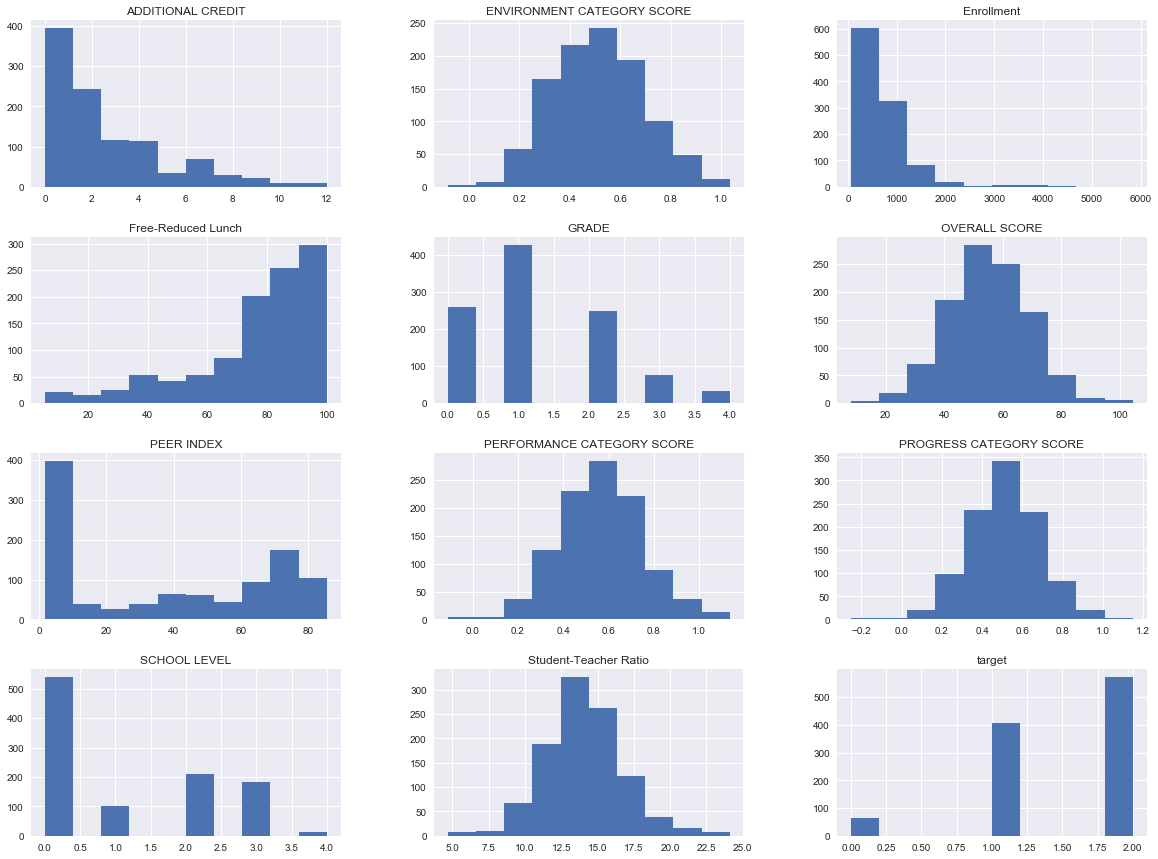

In [15]:
school_report.hist(figsize=(20,15));

#### Countplot
- Looking at the amount of each target that is in the dataset.
    - This shows that there is an imbalance between the different classes in the dataset. 

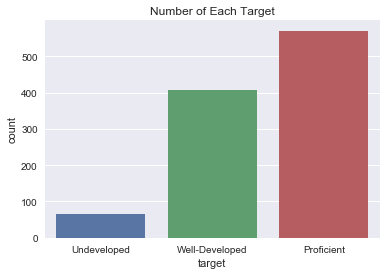

In [16]:
sns.countplot(x='target', data=school_report)
positions = (0, 1, 2)
labels = ('Undeveloped', 'Well-Developed', 'Proficient')
plt.xticks(positions, labels);
plt.title('Number of Each Target');

#### Trying to see if there's any relation between school level and grade with our target.
- These graphs shows that school level/grades do not give any indication if a school will fall into a certain target.

In [1]:
sns.barplot(x='SCHOOL LEVEL', y='OVERALL SCORE', data=school_report)
positions_school = (0, 1, 2, 3, 4)
labels_school = ('Elementary', 'K-8', 'Middle', 'High School', 'Transfer')
plt.xticks(positions_school, labels_school);

NameError: name 'sns' is not defined

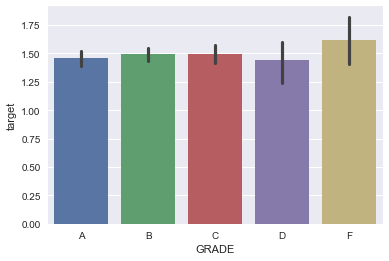

In [18]:
sns.barplot(x='GRADE', y='target', data=school_report)
positions = (0, 1, 2, 3, 4)
labels = ('A', 'B', 'C', 'D', 'F')
plt.xticks(positions, labels);

- Not many correlated features, only Progress Category Score and Overall Score.

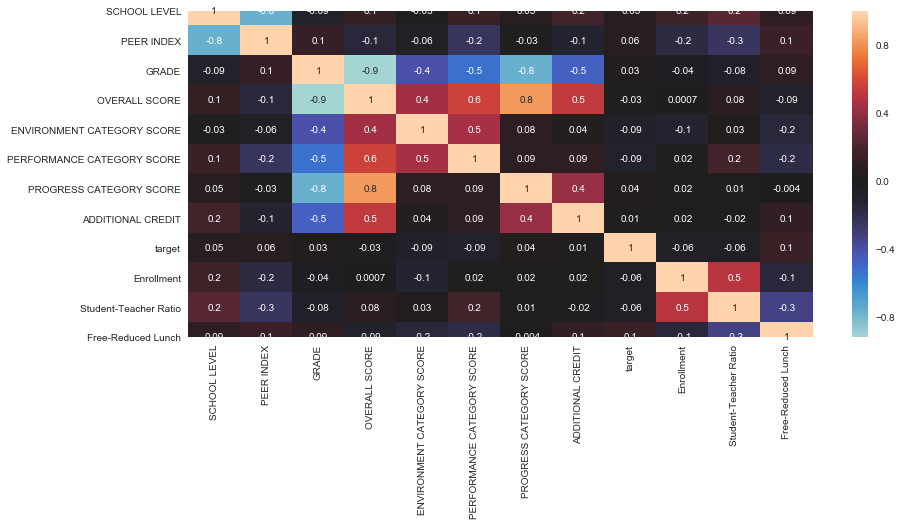

In [19]:
plt.figure(figsize=(14, 6))
sns.heatmap(school_report.corr(), annot=True, fmt='0.1g', center=0)
plt.show()

# Compare Models

#### SMOTE:
Since there was an imbalance between the classes, the method SMOTE can be used to help with the imbalance.  
   - SMOTE stands for Synthetic Minority Oversampling. Rather then oversampling the minority class with replacement (which simply adds duplicate cases to the dataset), the algorithm generates new sample data by creating 'synthetic' examples that are combinations of the closest minority class cases. 

#### Splitting the data:
1. Separate the data into it's features (X) and the the target (y).
2. Create training and test sets.  
    - ```test_size = .20``` is a fair split where 80% of the data is training the set and 20% is the testing set.
    - Use a ```random_state = 6 ``` to get the same result if trying this project out.
3. Normalize the data by using ```StandardScaler``` to make sure that all of the data is represented in the same scale.
4. Convert the train data into a DataFrame to view the scaled data - notice how the scaler also scaled the encoded columns, this does not have a negative effect on the model, because each value has been replaced with a corresponding decimal value, but it still only contains those 3 or 4 values.  The overall information content of each column has not changed.

In [20]:
X = school_report.drop(['target'], axis = 1)
y = school_report['target']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 6)

In [22]:
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

2    571
1    408
0     65
Name: target, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

2    451
1    451
0    451
dtype: int64


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [28]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train_resampled)
scaled_X_test = scaler.transform(X_test)

In [30]:
scaled_df_train = pd.DataFrame(scaled_X_train, columns=X_train.columns)
scaled_df_train.head()

SCHOOL LEVEL  PEER INDEX     GRADE  OVERALL SCORE  \
0     -0.906037    0.450624 -0.354234       0.286122   
1      0.770026   -1.125552 -0.354234       0.154130   
2     -0.906037    1.365143  1.703673      -1.222684   
3     -0.068006    0.214294 -0.354234       0.395357   
4     -0.906037    1.104824 -0.354234       0.109374   

   ENVIRONMENT CATEGORY SCORE  PERFORMANCE CATEGORY SCORE  \
0                   -0.105290                   -0.126882   
1                   -1.014861                    0.283780   
2                   -0.202539                    0.137517   
3                   -0.917611                   -0.188762   
4                   -0.597259                    1.346999   

   PROGRESS CATEGORY SCORE  ADDITIONAL CREDIT  Enrollment  \
0                 0.205442           1.147254   -0.212215   
1                 0.120943           0.841502   -0.448954   
2                -1.526786          -0.993007   -0.526506   
3                 0.471010           1.758757   -0.677530   
4                -0.518835           0.229999    0.142895   

   Student-Teacher Ratio  Free-Reduced Lunch  
0              -0.310142           -1.912449  
1              -0.474025            1.046364  
2               0.386360            0.968756  
3              -3.137122           -0.578558  
4              -0.105289           -1.068460

## KNN model

1. Instantiate KNeighborsClassifer
2. Fit the classifier 
    - (scaled _X_train, y_train)
3. Predict on the test set
    - scaled_X_test
4. Plot the confusion matrix: The diagonal represents where the predicted label is equal to the true label.  The off-diagonal elements are those that are mislabled by the classifier.  The higher the diagonal values of the matrix the better, indicating many correct perdictions.

In [32]:
KNN_clf = KNeighborsClassifier()
KNN_clf.fit(scaled_X_train, y_train_resampled)
KNN_preds = KNN_clf.predict(scaled_X_test)

In [104]:
print_metrics(y_test, KNN_preds)

Precision Score: 0.6619761240943067
Recall Score: 0.507177033492823
Accuracy Score: 0.507177033492823
F1 Score: 0.5347180428306301


- Precision Score is .586 which says that the ratio of not labeling negatives as positives is 59%.
- Recall Score is .602 which says that the ratio of having all positives is 60%.
- Accurary Score is .602 which says that the percent of correct predictions is 60%.
- F1 score is .593 which says that the average of precision and recall is 59%.

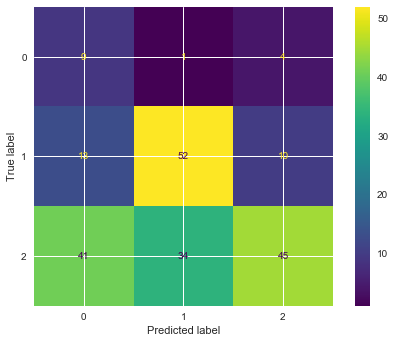

In [76]:
plot_confusion_matrix(KNN_clf, scaled_X_test, y_test);

- The confusion matrix shows that there are still many elements that are mislabeled in this model.

### Improve KNN model performance

In [35]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0
    for i in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_test)
        f1_scores = f1_score(y_test, predictions, average='weighted')
        if f1_scores > best_score:
            best_score = f1_scores
            best_k = i
        print('Best Value for k:', best_k)
        print('F1 score achieved:', best_score)

In [36]:
find_best_k(scaled_X_train, y_train_resampled, scaled_X_test, y_test)

Best Value for k: 1
F1 score achieved: 0.52480987043508
Best Value for k: 3
F1 score achieved: 0.5540066856818996
Best Value for k: 3
F1 score achieved: 0.5540066856818996
Best Value for k: 3
F1 score achieved: 0.5540066856818996
Best Value for k: 3
F1 score achieved: 0.5540066856818996
Best Value for k: 3
F1 score achieved: 0.5540066856818996
Best Value for k: 3
F1 score achieved: 0.5540066856818996
Best Value for k: 3
F1 score achieved: 0.5540066856818996
Best Value for k: 3
F1 score achieved: 0.5540066856818996
Best Value for k: 3
F1 score achieved: 0.5540066856818996
Best Value for k: 3
F1 score achieved: 0.5540066856818996
Best Value for k: 3
F1 score achieved: 0.5540066856818996
Best Value for k: 3
F1 score achieved: 0.5540066856818996


- The best value for k that will give a better F1 score, is 3 with an F1 score of 55%.

- Run the KNN model again with the best k of 3, shows an improved Accuracy Score by 3%.

In [37]:
KNN_clf_improved = KNeighborsClassifier(n_neighbors = 3)
KNN_clf_improved.fit(scaled_X_train, y_train_resampled)
KNN_preds_improved = KNN_clf_improved.predict(scaled_X_test)

In [38]:
print_metrics(y_test, KNN_preds_improved)

Precision Score: 0.6322597139294054
Recall Score: 0.5311004784688995
Accuracy Score: 0.5311004784688995
F1 Score: 0.5540066856818996


In [108]:
KNN_prec = round(precision_score(y_test, KNN_preds_improved, average='weighted')*100, 2)
KNN_recall = round(recall_score(y_test, KNN_preds_improved, average='weighted')*100, 2)
KNN_acc = round(accuracy_score(y_test, KNN_preds_improved)*100, 2)
KNN_f1 = round(f1_score(y_test, KNN_preds_improved, average='weighted')*100, 2)

#### Plot the confusion matrix

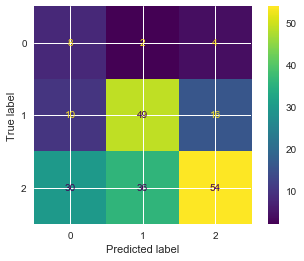

In [49]:
plot_confusion_matrix(KNN_clf_improved, scaled_X_test, y_test);

# Decision Tree Model

1. Instantiate DecisionTreeClassifier with ```random_state = 6``` to keep it the same.
2. Fit the classifier 
    - (scaled _X_train, y_train)
3. Predict on the test set
    - scaled_X_test
4. Possibility: Can make a plot the DOT data graph.
5. Check predictive performance.
6. Plot the confusion matrix: The diagonal represents where the predicted label is equal to the true label.  The off-diagonal elements are those that are mislabled by the classifier.  The higher the diagonal values of the matrix the better, indicating many correct perdictions.

In [41]:
dt_clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 6)
dt_clf.fit(scaled_X_train, y_train_resampled)
dt_preds = dt_clf.predict(scaled_X_test)

In [42]:
dot_data = export_graphviz(dt_clf, out_file=None, feature_names=scaled_df_train.columns,
                          class_names=np.unique(y).astype('str'), filled=True, rounded=True, 
                           special_characters=True)
graph = graph_from_dot_data(dot_data)
Image(graph.create_png())

In [43]:
print_metrics(y_test, dt_preds)

Precision Score: 0.49943246546117365
Recall Score: 0.4880382775119617
Accuracy Score: 0.4880382775119617
F1 Score: 0.49260302592226496


- Precision Score is .499 which says that the ratio of not labeling negatives as positives is 50%.
- Recall Score is .488 which says that the ratio of having all positives is 49%.
- Accurary Score is .488 which says that the percent of correct predictions is 49%.
- F1 score is .492 which says that the average of precision and recall is 50%.

In [109]:
dt_prec = round(precision_score(y_test, dt_preds, average='weighted')*100, 2)
dt_recall = round(recall_score(y_test, dt_preds, average='weighted')*100, 2)
dt_acc = round(accuracy_score(y_test, dt_preds)*100, 2)
dt_f1 = round(f1_score(y_test, dt_preds, average='weighted')*100, 2)

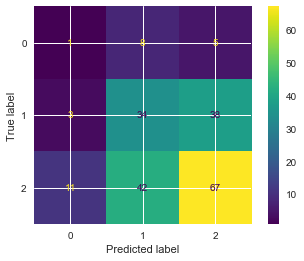

In [50]:
plot_confusion_matrix(dt_clf, scaled_X_test, y_test);

- The confusion matrix shows that there are still many elements that are mislabeled in this model.

### Improve Decision Tree model performance using GridSearchCV

1. Criterion
2. Maximum tree depth
3. Minimum samples split
4. Minimum samples leafs
5. Maximum features

In [52]:
param_grid = {'criterion': ['gini', 'entropy'],
            'max_depth': range(1, 19, 19),
            'min_samples_split': [2, 4, 5, 6, 7, 8, 9, 10],
            'min_samples_leaf': [1, 2, 3, 4, 5, 6],
            'max_features': range(1,11, 11)}
dt = DecisionTreeClassifier(random_state = 6)
dt_grid = GridSearchCV(dt, param_grid, cv = 3, scoring = 'accuracy' , n_jobs=-1)
dt_grid.fit(scaled_X_train, y_train_resampled)

print("Best parameters:", dt_grid.best_params_)

Best parameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [62]:
dt_clf_improved = DecisionTreeClassifier(criterion = 'gini', max_depth = 1, min_samples_leaf = 1,
                                        min_samples_split = 2, max_features = 1, random_state = 6)
dt_clf_improved.fit(scaled_X_train, y_train_resampled)
dt_preds_improved = dt_clf_improved.predict(scaled_X_test)

In [61]:
print_metrics(y_test, dt_preds_improved)

Precision Score: 0.16875894046268436
Recall Score: 0.2583732057416268
Accuracy Score: 0.2583732057416268
F1 Score: 0.1942311734233399


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Run the Decision Tree model again with the best parameters, shows an improved Accuracy Score by 1%, but the precision score lowered significantly.

# Random Forest

In [63]:
random_clf = RandomForestClassifier(random_state = 6)
random_clf.fit(scaled_X_train, y_train_resampled)
random_preds = random_clf.predict(scaled_X_test)

In [64]:
print_metrics(y_test, random_preds)

Precision Score: 0.6038903112944147
Recall Score: 0.6028708133971292
Accuracy Score: 0.6028708133971292
F1 Score: 0.6033173279384784


In [110]:
ran_prec = round(precision_score(y_test, random_preds, average='weighted')*100, 2)
ran_recall = round(recall_score(y_test, random_preds, average='weighted')*100, 2)
ran_acc = round(accuracy_score(y_test, random_preds)*100, 2)
ran_f1 = round(f1_score(y_test, random_preds, average='weighted')*100, 2)

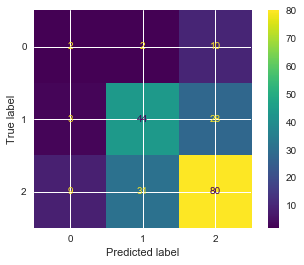

In [65]:
plot_confusion_matrix(random_clf, scaled_X_test, y_test);

In [66]:
importances = pd.DataFrame({'feature': scaled_df_train.columns,'importance':np.round(random_clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

importance
feature                               
PERFORMANCE CATEGORY SCORE       0.138
ENVIRONMENT CATEGORY SCORE       0.133
Enrollment                       0.119
PEER INDEX                       0.104
GRADE                            0.084
OVERALL SCORE                    0.076
Student-Teacher Ratio            0.074
Free-Reduced Lunch               0.073
PROGRESS CATEGORY SCORE          0.072
ADDITIONAL CREDIT                0.067
SCHOOL LEVEL                     0.060

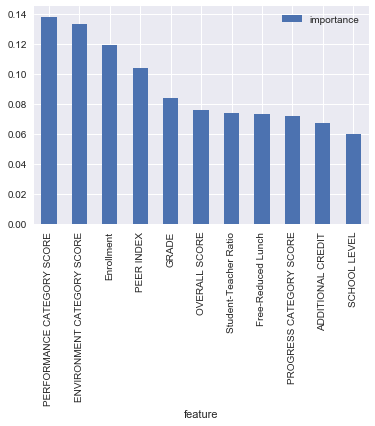

In [67]:
importances.plot.bar();

# Gradiant Boosting

1. Instantiate GradientBoostingClassifier with ```random_state = 6``` to keep it the same.
2. Fit the classifier 
    - (scaled _X_train, y_train_resampled)
3. Predict on the test set
    - scaled_X_test
4. Check predictive performance.  Use the model to predict labels on both the training and test set.
5. Calculate the accuracy and f1-score for each model.
6. Plot the confusion matrix: The diagonal represents where the predicted label is equal to the true label.  The off-diagonal elements are those that are mislabled by the classifier.  The higher the diagonal values of the matrix the better, indicating many correct perdictions.

In [112]:
gbt_clf = GradientBoostingClassifier(random_state = 6)
gbt_clf.fit(scaled_X_train, y_train_resampled)
gbt_preds = gbt_clf.predict(scaled_X_test)

In [113]:
print_metrics(y_test, gbt_preds)

Precision Score: 0.5938338768745582
Recall Score: 0.5980861244019139
Accuracy Score: 0.5980861244019139
F1 Score: 0.5958832577675583


In [114]:
gbt_prec = round(precision_score(y_test, gbt_preds, average='weighted')*100, 2)
gbt_recall = round(recall_score(y_test, gbt_preds, average='weighted')*100, 2)
gbt_acc = round(accuracy_score(y_test, gbt_preds)*100, 2)
gbt_f1 = round(f1_score(y_test, gbt_preds, average='weighted')*100, 2)

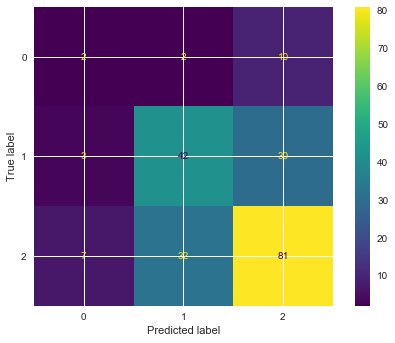

In [74]:
plot_confusion_matrix(gbt_clf, scaled_X_test, y_test);

# Adaboost

1. Instantiate AdaBoostClassifier with ```random_state = 6``` to keep it the same.
2. Fit the classifier 
    - (scaled _X_train, y_train_resampled)
3. Predict on the test set
    - scaled_X_test
4. Check predictive performance.  Use the model to predict labels on both the training and test set.
5. Calculate the percision, recall, accuracy and f1-score.
6. Plot the confusion matrix: The diagonal represents where the predicted label is equal to the true label.  The off-diagonal elements are those that are mislabled by the classifier.  The higher the diagonal values of the matrix the better, indicating many correct perdictions.

In [77]:
adaboost_clf = AdaBoostClassifier(random_state = 6)
adaboost_clf.fit(scaled_X_train, y_train_resampled)
adaboost_preds = adaboost_clf.predict(scaled_X_test)

In [78]:
print_metrics(y_test, adaboost_preds)

Precision Score: 0.5638247201714695
Recall Score: 0.5215311004784688
Accuracy Score: 0.5215311004784688
F1 Score: 0.5281138422745789


In [115]:
ada_prec = round(precision_score(y_test, adaboost_preds, average='weighted')*100, 2)
ada_recall = round(recall_score(y_test, adaboost_preds, average='weighted')*100, 2)
ada_acc = round(accuracy_score(y_test, adaboost_preds)*100, 2)
ada_f1 = round(f1_score(y_test, adaboost_preds, average='weighted')*100, 2)

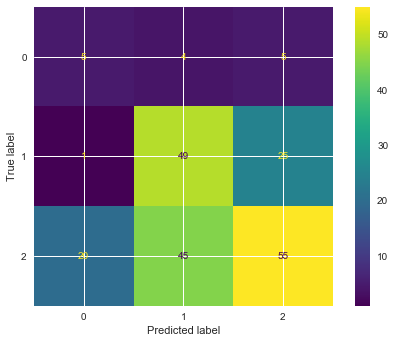

In [79]:
plot_confusion_matrix(adaboost_clf, scaled_X_test, y_test);

# XGBoost

1. Instantiate XGBClassifier with ```random_state = 6``` to keep it the same.
2. Fit the classifier 
    - (scaled _X_train, y_train_resampled)
3. Predict on the test set
    - scaled_X_test
4. Check predictive performance.  Use the model to predict labels on both the training and test set.
5. Calculate the percision, recall, accuracy and f1-score.
6. Plot the confusion matrix: The diagonal represents where the predicted label is equal to the true label.  The off-diagonal elements are those that are mislabled by the classifier.  The higher the diagonal values of the matrix the better, indicating many correct perdictions.

In [82]:
xgboost_clf = XGBClassifier(random_state = 6)
xgboost_clf.fit(scaled_X_train, y_train_resampled)
xgboost_preds = xgboost_clf.predict(scaled_X_test)

In [102]:
print_metrics(y_test, xgboost_preds)

Precision Score: 0.613035337534794
Recall Score: 0.5980861244019139
Accuracy Score: 0.5980861244019139
F1 Score: 0.6046521261832266


In [116]:
xg_prec = round(precision_score(y_test, xgboost_preds, average='weighted')*100, 2)
xg_recall = round(recall_score(y_test, xgboost_preds, average='weighted')*100, 2)
xg_acc = round(accuracy_score(y_test, xgboost_preds)*100, 2)
xg_f1 = round(f1_score(y_test, xgboost_preds, average='weighted')*100, 2)

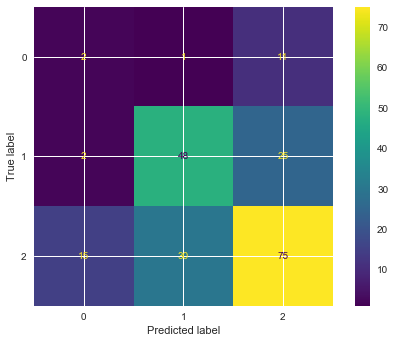

In [96]:
plot_confusion_matrix(xgboost_clf, scaled_X_test, y_test);

### Improve XGBoost model performance using GridSearchCV

1. Learning rate
2. Maximum depth
3. Minimum child weight
4. Subsamples
5. n_estimators

In [93]:
param_grid_xg = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5, 6, 7],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

- source for code below: Learn.co section 35 Ensemble Methods - XGBoost

In [95]:
grid_clf = GridSearchCV(xgboost_clf, param_grid_xg, scoring='accuracy', cv=5, n_jobs=1)
grid_clf.fit(scaled_X_train, y_train_resampled)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

test_preds = grid_clf.predict(scaled_X_test)

print('')
print_metrics(y_test, test_preds)

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.5

Precision Score: 0.5673095137704939
Recall Score: 0.569377990430622
Accuracy Score: 0.569377990430622
F1 Score: 0.5679151357117459


# DataFrame of all the models with their scores

In [123]:
data = {'Model': ['KNN', 'Decision Tree', 'Random Forest', 'Gadriant Boosting', 'AdaBoost', 'XGBoost'],
         'Precision Score': [KNN_prec, dt_prec, ran_prec, gbt_prec, ada_prec, xg_prec],
         'Recall Score': [KNN_recall, dt_recall, ran_recall, gbt_recall, ada_recall, xg_recall],
         'Accuracy Score': [KNN_acc, dt_acc, ran_acc, gbt_acc, ada_acc, xg_acc],
         'F1 Score': [KNN_f1, dt_f1, ran_f1, gbt_f1, ada_f1, xg_f1]}
model_performance = pd.DataFrame(data)
model_performance.sort_values(by='Accuracy Score', ascending=False)

Model  Precision Score  Recall Score  Accuracy Score  F1 Score
2      Random Forest            60.39         60.29           60.29     60.33
3  Gadriant Boosting            59.38         59.81           59.81     59.59
5            XGBoost            61.30         59.81           59.81     60.47
0                KNN            63.23         53.11           53.11     55.40
4           AdaBoost            56.38         52.15           52.15     52.81
1      Decision Tree            49.94         48.80           48.80     49.26